# Importing Libaries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from data_cleaning import data_cleaner

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from data_preprocessing import data_preprocessor

from modelling import classification_metrics, custom_confusion_matrix, model_report, build_nn, voting_classifier, stacked_model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier

from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data Cleaning

In [0]:
data_cleaner('data/cardio_data.csv', 'data/cardio_data_clean.csv')

In [2]:
cardio_data = pd.read_csv('cardio_data_clean.csv')
cardio_data.head()

,age,gender,blood_pressure_max,blood_pressure_min,cholesterol_level,glucose_level,smoking_status,alcohol_status,activity_level,disease,bmi
0,39,1,110,70,1,1,0,0,1,1,31
1,64,1,120,70,1,1,0,0,1,1,26
2,55,0,140,90,2,2,0,0,1,1,31
3,54,0,130,80,1,3,0,0,1,1,29
4,60,1,120,80,2,2,0,1,1,1,20


# EDA

In [0]:
# EDA.ipynb notebook

# Data Preprocessing

In [0]:
X = cardio_data.drop(columns = ['disease'])
y = cardio_data['disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [0]:
X_train_scaled = data_preprocessor(X_train)
X_test_scaled = data_preprocessor(X_test)

X_train_binned = data_preprocessor(X_train, bins = True)
X_test_binned = data_preprocessor(X_test, bins = True)

# Modelling

## Logistic Regression

### Training Model

In [0]:
lr = LogisticRegression()
lr_model = lr.fit(X_train_scaled, y_train)

y_test_hat = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:,1]

### Model Report

Logistic Regression Model Report


- performance metrics (default threshold):

accuracy = 0.731, auc_score = 0.731

precision = 0.758, recall = 0.679, f1-score = 0.716

- ROC curve:



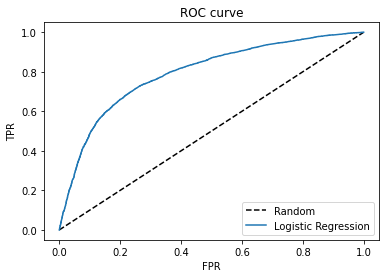


- optimal probability threshold:

0.46

- precision recall tradeoff:



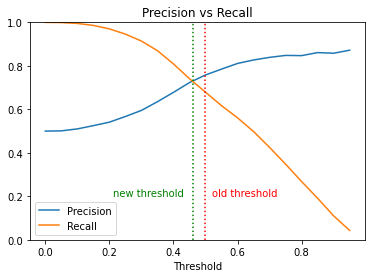


- performance metrics (new threshold):

accuracy = 0.732, auc_score = 0.732

precision = 0.734, recall = 0.728, f1-score = 0.731

- confusion matrix:



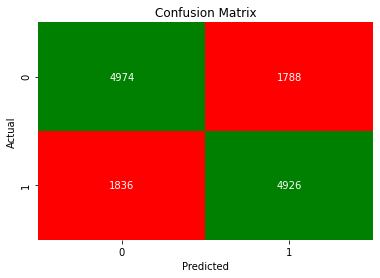

In [16]:
model_report(y_test, y_test_hat, y_test_proba, "Logistic Regression")

### Plotting Coefficients

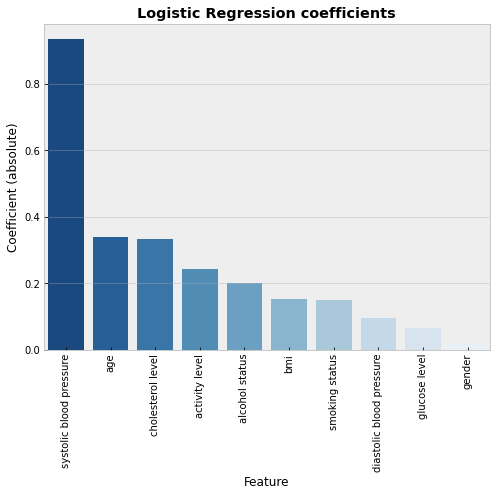

In [0]:
lr_coeffs = pd.DataFrame(list(zip(X_train_scaled.columns, np.absolute(lr_model.coef_[0]))), columns = ['feature', 'coefficient magnitude'])
lr_coeffs_sorted = lr_coeffs.sort_values(by = 'coefficient magnitude', ascending = False)

plt.style.use('bmh')

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
sns.barplot(data = lr_coeffs_sorted, x = 'feature', y = 'coefficient magnitude', ax = ax, palette = 'Blues_r')
ax.set_title('Logistic Regression coefficients', fontweight = 'bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient (absolute)')
ax.set_xticklabels(['systolic blood pressure', 'age', 'cholesterol level', 'activity level', 'alcohol status', 'bmi', 'smoking status', 'diastolic blood pressure', 'glucose level', 'gender'])
plt.xticks(rotation = 90);

## k-Nearest Neighbours

### Baseline Model

#### Training Model

In [0]:
knn = KNeighborsClassifier()
base_knn_model = knn.fit(X_train_scaled, y_train)

y_test_hat = base_knn_model.predict(X_test_scaled)
y_test_proba = base_knn_model.predict_proba(X_test_scaled)

#### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.694, auc_score = 0.694

precision = 0.696, recall = 0.688, f1-score = 0.692


### Hyperparameter Tuning

#### Inspecting range for k

In [0]:
ks = range(5,105,5)
scores = []
for k in ks:
    knn = KNeighborsClassifier(n_neighbors = k)
    score = np.mean(cross_val_score(knn, X_train_scaled, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

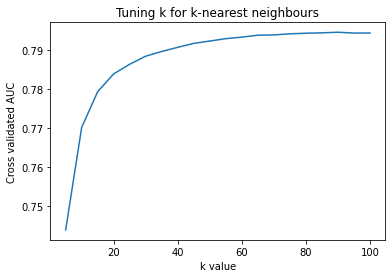

In [0]:
plt.plot(ks, scores)
plt.title('Tuning k for k-nearest neighbours')
plt.xlabel('k value')
plt.ylabel('Cross validated AUC');

#### Tuning k, distance and weight metric

In [0]:
param_grid = {'n_neighbors': range(40,120,20), 'weights': ['uniform', 'distance'], 'metric': ['manhattan', 'euclidean']}
knn_gs = GridSearchCV(knn, param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
%time knn_gs.fit(X_train_scaled, y_train)
knn_gs.best_params_

CPU times: user 2.17 s, sys: 120 ms, total: 2.29 s
Wall time: 3min 55s


{'metric': 'manhattan', 'n_neighbors': 100, 'weights': 'uniform'}

### Tuned Model

#### Training Model

In [0]:
tuned_knn = KNeighborsClassifier(n_neighbors = 100, metric = 'manhattan')
tuned_knn_model = tuned_knn.fit(X_train_scaled, y_train)

y_test_hat = tuned_knn_model.predict(X_test_scaled)
y_test_proba = tuned_knn_model.predict_proba(X_test_scaled)[:,1]

#### Model Report

k-Nearest Neighbours Model Report


- performance metrics (default threshold):

accuracy = 0.734, auc_score = 0.734

precision = 0.759, recall = 0.684, f1-score = 0.72

- ROC curve:



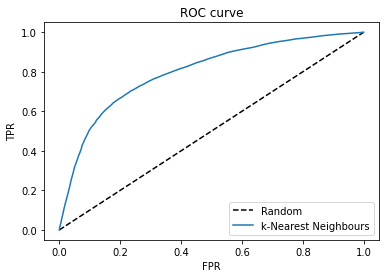


- optimal probability threshold:

0.49

- precision recall tradeoff:



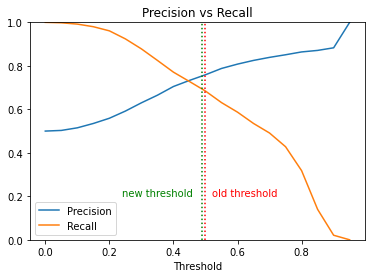


- performance metrics (new threshold):

accuracy = 0.733, auc_score = 0.733

precision = 0.754, recall = 0.693, f1-score = 0.722

- confusion matrix:



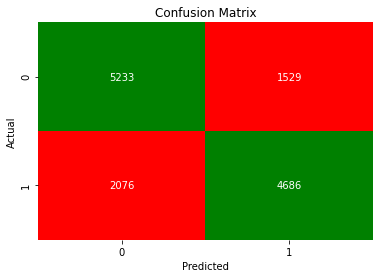

In [18]:
model_report(y_test, y_test_hat, y_test_proba, "k-Nearest Neighbours")

## Naive Bayes Classifier

### Training Model

In [0]:
nb = CategoricalNB()
nb_model = nb.fit(X_train_binned, y_train)

y_test_hat = nb_model.predict(X_test_binned)
y_test_proba = nb_model.predict_proba(X_test_binned)[:,1]

### Model Report

Categorical Naive Bayes Model Report


- performance metrics (default threshold):

accuracy = 0.72, auc_score = 0.72

precision = 0.754, recall = 0.654, f1-score = 0.7

- ROC curve:



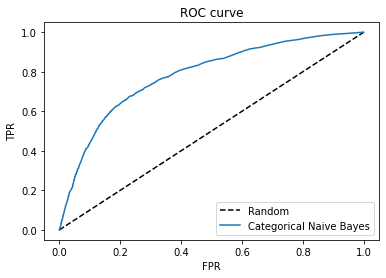


- optimal probability threshold:

0.359

- precision recall tradeoff:



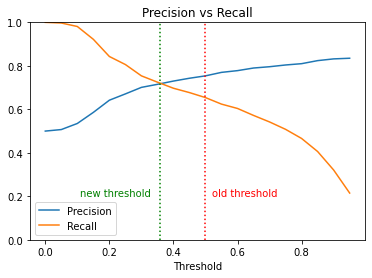


- performance metrics (new threshold):

accuracy = 0.719, auc_score = 0.719

precision = 0.721, recall = 0.714, f1-score = 0.717

- confusion matrix:



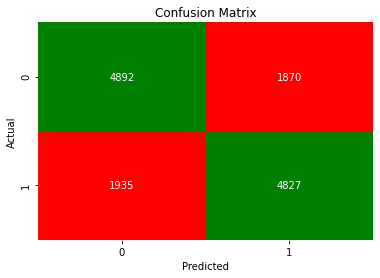

In [9]:
model_report(y_test, y_test_hat, y_test_proba, "Categorical Naive Bayes")

## Support Vector Machine

### Linear SVM

#### Training Model

In [0]:
linear_svm = LinearSVC()
linear_svm_model = linear_svm.fit(X_train_scaled, y_train)

y_test_hat = linear_svm_model.predict(X_test_scaled)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.729, auc_score = 0.729

precision = 0.761, recall = 0.668, f1-score = 0.711


#### Plotting Confusion Matrix

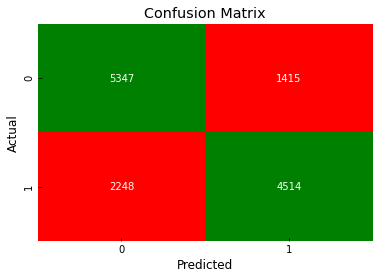

In [0]:
custom_confusion_matrix(y_test, y_test_hat)

#### Plotting Coefficients

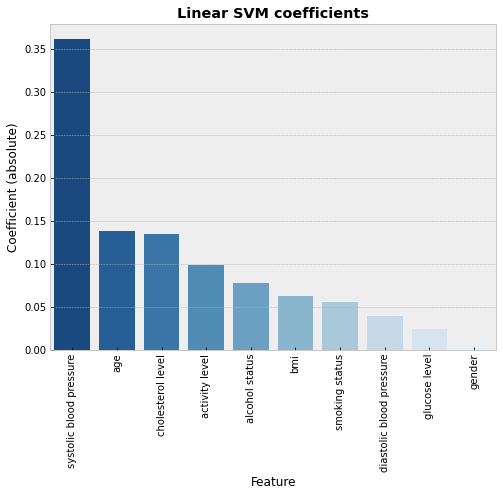

In [0]:
svm_coeffs = pd.DataFrame(list(zip(X_train_scaled.columns, np.absolute(linear_svm_model.coef_[0]))), columns = ['feature', 'coefficient magnitude'])
svm_coeffs_sorted = lr_coeffs.sort_values(by = 'coefficient magnitude', ascending = False)

plt.style.use('bmh')

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
sns.barplot(data = svm_coeffs_sorted, x = 'feature', y = 'coefficient magnitude', ax = ax, palette = 'Blues_r')
ax.set_title('Linear SVM coefficients', fontweight = 'bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient (absolute)')
ax.set_xticklabels(['systolic blood pressure', 'age', 'cholesterol level', 'activity level', 'alcohol status', 'bmi', 'smoking status', 'diastolic blood pressure', 'glucose level', 'gender'])
plt.xticks(rotation = 90);

### Polynomial SVM

#### Training Model

In [0]:
poly_svm = SVC(kernel = 'poly')
%time poly_svm_model = poly_svm.fit(X_train_scaled, y_train)

y_test_hat = poly_svm_model.predict(X_test_scaled)

CPU times: user 1min 27s, sys: 126 ms, total: 1min 27s
Wall time: 1min 27s


#### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.723, auc_score = 0.723

precision = 0.74, recall = 0.686, f1-score = 0.712


#### Plotting Confusion Matrix

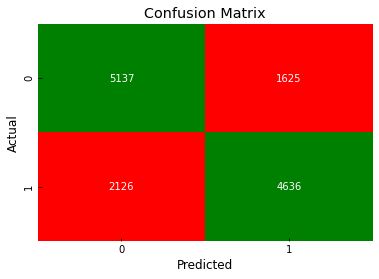

In [0]:
custom_confusion_matrix(y_test, y_test_hat)

### Radial SVM

#### Training Model

In [14]:
rbf_svm = SVC(kernel = 'rbf')
%time rbf_svm_model = rbf_svm.fit(X_train_scaled, y_train)

y_test_hat = rbf_svm_model.predict(X_test_scaled)

CPU times: user 2min 14s, sys: 262 ms, total: 2min 14s
Wall time: 2min 14s


#### Validating Model

In [22]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.737, auc_score = 0.737

precision = 0.769, recall = 0.677, f1-score = 0.72


#### Plotting Confusion Matrix

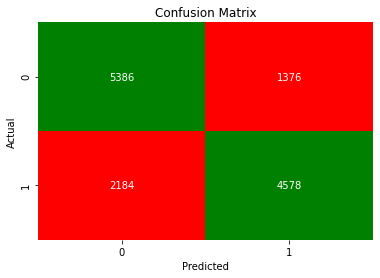

In [23]:
custom_confusion_matrix(y_test, y_test_hat)

### Sigmoid SVM

#### Training Model

In [0]:
sigmoid_svm = SVC(kernel = 'sigmoid')
%time sigmoid_svm_model = sigmoid_svm.fit(X_train_scaled, y_train)

y_test_hat = sigmoid_svm_model.predict(X_test_scaled)

CPU times: user 2min 11s, sys: 39 ms, total: 2min 11s
Wall time: 2min 11s


#### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.65, auc_score = 0.65

precision = 0.651, recall = 0.647, f1-score = 0.649


#### Plotting Confusion Matrix

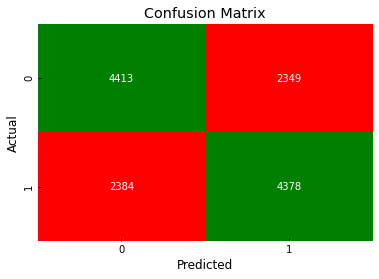

In [0]:
custom_confusion_matrix(y_test, y_test_hat)

## Nueral Network

### Baseline Model

#### Training Model

In [0]:
nn = build_nn()
nn.fit(X_train_scaled, y_train, epochs = 5, verbose = 0)

y_test_proba = nn.predict(X_test_scaled).reshape(-1)
y_test_hat = pd.Series(y_test_proba).map(lambda x: 1 if x > 0.5 else 0)

#### Validating Model

In [6]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.733, auc_score = 0.733

precision = 0.743, recall = 0.711, f1-score = 0.727


### Hyperparameter Tuning

#### Tuning number of hidden layers and number of nuerons per layer

In [0]:
# creating sklearn wrapper for keras nueral network model
keras_nn = KerasClassifier(build_nn)

param_grid = {'hidden_layers': range(1,6), 'units': range(5,30,5)}
nn_gs = GridSearchCV(keras_nn, param_grid, cv = 5)
%time nn_gs.fit(X_train_scaled, y_train, batch_size = 512, epochs = 5, verbose = 0)
nn_gs.best_params_

### Tuned Model

#### Training Model

In [0]:
tuned_nn = build_nn(hidden_layers = 2, units = 25)
tuned_nn.fit(X_train_scaled, y_train, epochs = 5, verbose = 0)

y_test_proba = tuned_nn.predict(X_test_scaled).reshape(-1)
y_test_hat = pd.Series(y_test_proba).map(lambda x: 1 if x > 0.5 else 0)

#### Model Report

Nueral Network Model Report


- performance metrics (default threshold):

accuracy = 0.737, auc_score = 0.737

precision = 0.765, recall = 0.683, f1-score = 0.722

- ROC curve:



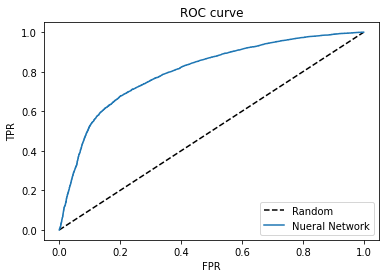


- optimal probability threshold:

0.468

- precision recall tradeoff:



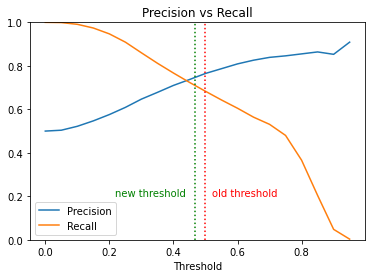


- performance metrics (new threshold):

accuracy = 0.736, auc_score = 0.736

precision = 0.748, recall = 0.711, f1-score = 0.729

- confusion matrix:



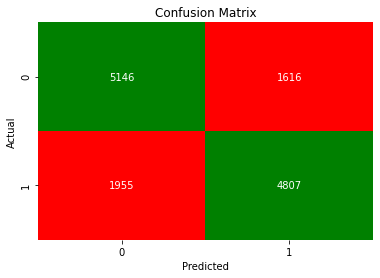

In [8]:
model_report(y_test, y_test_hat, y_test_proba, "Nueral Network")

## Decision Tree

### Baseline Model

#### Training Model

In [0]:
tree = DecisionTreeClassifier()
base_tree_model = tree.fit(X_train_binned, y_train)

y_test_hat = base_tree_model.predict(X_test_binned)

#### Valdiating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.707, auc_score = 0.707

precision = 0.733, recall = 0.651, f1-score = 0.69


### Hyperparameter Tuning

#### Inspecting range for max depth

In [0]:
depths = range(1,11)
scores = []
for depth in depths:
    tree = DecisionTreeClassifier(max_depth = depth)
    score = np.mean(cross_val_score(tree, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

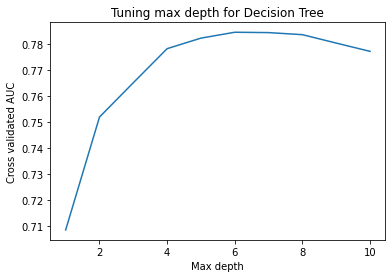

In [0]:
plt.plot(depths, scores)
plt.title('Tuning max depth for Decision Tree')
plt.xlabel('Max depth')
plt.ylabel('Cross validated AUC');

#### Inspecting range for minimum samples leaf

In [0]:
sample_sizes = range(25,525,25)
scores = []
for sample_size in sample_sizes:
    tree = DecisionTreeClassifier(min_samples_leaf = sample_size)
    score = np.mean(cross_val_score(tree, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

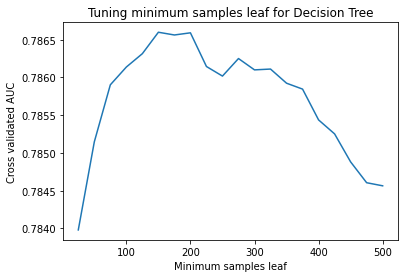

In [0]:
plt.plot(samples, scores)
plt.title('Tuning minimum samples leaf for Decision Tree')
plt.xlabel('Minimum samples leaf')
plt.ylabel('Cross validated AUC');

#### Tuning max depth, minimum samples leaf and impurity criterion

In [0]:
param_grid = {'max_depth': range(4,11), 'min_samples_leaf': range(100,300,50), 'criterion': ['gini', 'entropy']}
tree_gs = GridSearchCV(tree, param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
%time tree_gs.fit(X_train_binned, y_train)
tree_gs.best_params_

CPU times: user 1.95 s, sys: 198 ms, total: 2.15 s
Wall time: 15 s


{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 150}

### Tuned Model

#### Training Model

In [0]:
tuned_tree = DecisionTreeClassifier(min_samples_leaf = 150)
tuned_tree_model = tuned_tree.fit(X_train_binned, y_train)

y_test_hat = tuned_tree_model.predict(X_test_binned)
y_test_proba = tuned_tree_model.predict_proba(X_test_binned)[:,1]

#### Model Report

Decision Tree Model Report


- performance metrics (default threshold):

accuracy = 0.729, auc_score = 0.729

precision = 0.741, recall = 0.704, f1-score = 0.722

- ROC curve:



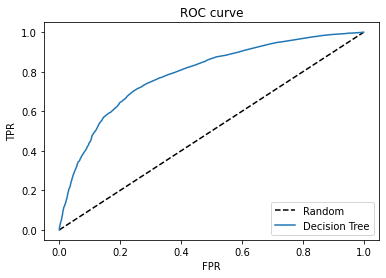


- optimal probability threshold:

0.476

- precision recall tradeoff:



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


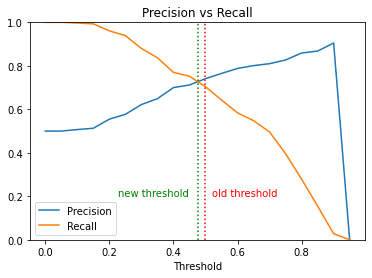


- performance metrics (new threshold):

accuracy = 0.729, auc_score = 0.729

precision = 0.738, recall = 0.71, f1-score = 0.724

- confusion matrix:



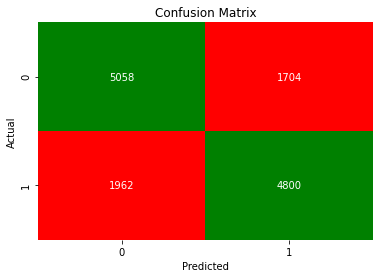

In [25]:
model_report(y_test, y_test_hat, y_test_proba, "Decision Tree")

#### Plotting Feature Importances

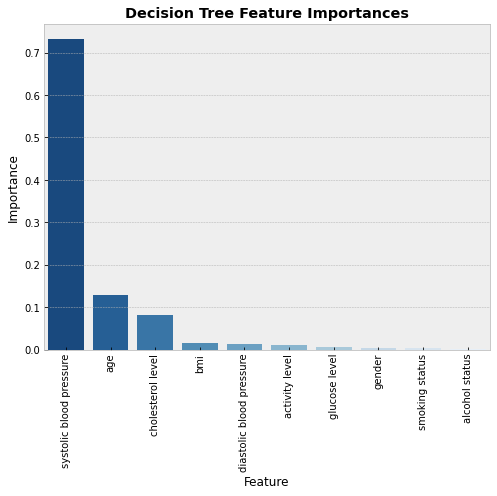

In [0]:
tree_feature_importances = pd.DataFrame(list(zip(X_train_binned.columns, np.absolute(tuned_tree_model.feature_importances_))), columns = ['feature', 'importance'])
tree_feature_importances_sorted = tree_feature_importances.sort_values(by = 'importance', ascending = False)

plt.style.use('bmh')

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
sns.barplot(data = tree_feature_importances_sorted, x = 'feature', y = 'importance', ax = ax, palette = 'Blues_r')
ax.set_title('Decision Tree Feature Importances', fontweight = 'bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_xticklabels(['systolic blood pressure', 'age', 'cholesterol level', 'bmi', 'diastolic blood pressure', 'activity level', 'glucose level', 'gender', 'smoking status', 'alcohol status'])
plt.xticks(rotation = 90);

## Random Forests

### Vanilla Random Forest

#### Baseline Model

##### Training Model

In [0]:
forest = RandomForestClassifier()
base_forest_model = forest.fit(X_train_binned, y_train)

y_test_hat = base_forest_model.predict(X_test_binned)

##### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.715, auc_score = 0.715

precision = 0.733, recall = 0.678, f1-score = 0.704


#### Hyperparameter Tuning

##### Inspecting range for number of trees

In [0]:
n_trees = range(10,160,10)
scores = []
for n in n_trees:
    forest = RandomForestClassifier(n_estimators = n)
    score = np.mean(cross_val_score(forest, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

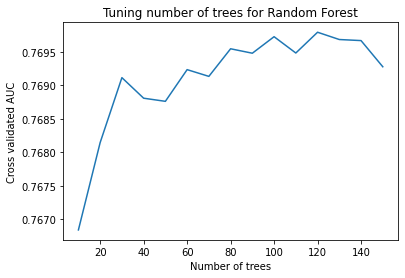

In [0]:
plt.plot(n_trees, scores)
plt.title('Tuning number of trees for Random Forest')
plt.xlabel('Number of trees')
plt.ylabel('Cross validated AUC');

##### Inspecting range for max depth

In [0]:
depths = range(1,11)
scores = []
for depth in depths:
    forest = RandomForestClassifier(max_depth = depth)
    score = np.mean(cross_val_score(forest, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

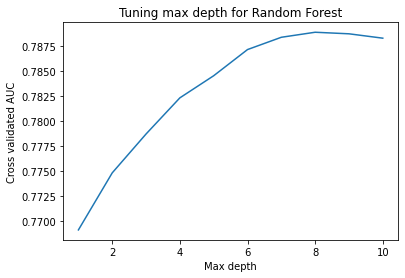

In [0]:
plt.plot(depths, scores)
plt.title('Tuning max depth for Random Forest')
plt.xlabel('Max depth')
plt.ylabel('Cross validated AUC');

##### Tuning number of trees, max depth and impurity criterion

In [0]:
param_grid = {'n_estimators': range(80,140,20), 'max_depth': range(6,11), 'criterion': ['gini', 'entropy']}
forest_gs = GridSearchCV(forest, param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
%time forest_gs.fit(X_train_binned, y_train)
forest_gs.best_params_

CPU times: user 3.73 s, sys: 238 ms, total: 3.97 s
Wall time: 2min 50s


{'criterion': 'gini', 'max_depth': 9, 'n_estimators': 100}

#### Tuned Model

##### Training Model

In [0]:
tuned_forest = RandomForestClassifier(max_depth = 9)
tuned_forest_model = tuned_forest.fit(X_train_binned, y_train)

y_test_hat = tuned_forest_model.predict(X_test_binned)
y_test_proba = tuned_forest_model.predict_proba(X_test_binned)[:,1]

##### Model Report

Random Forest Model Report


- performance metrics (default threshold):

accuracy = 0.728, auc_score = 0.728

precision = 0.746, recall = 0.691, f1-score = 0.717

- ROC curve:



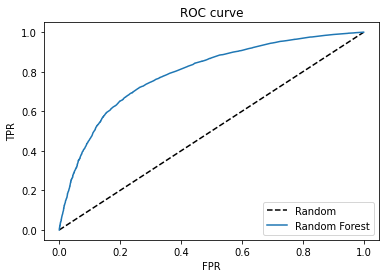


- optimal probability threshold:

0.475

- precision recall tradeoff:



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


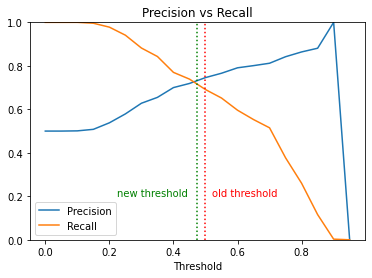


- performance metrics (new threshold):

accuracy = 0.728, auc_score = 0.728

precision = 0.733, recall = 0.717, f1-score = 0.725

- confusion matrix:



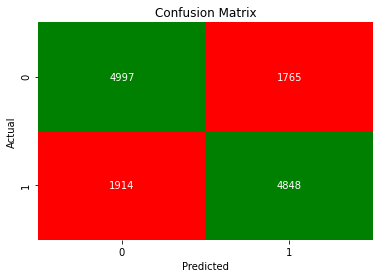

In [21]:
model_report(y_test, y_test_hat, y_test_proba, 'Random Forest')

##### Plotting Feature Importances

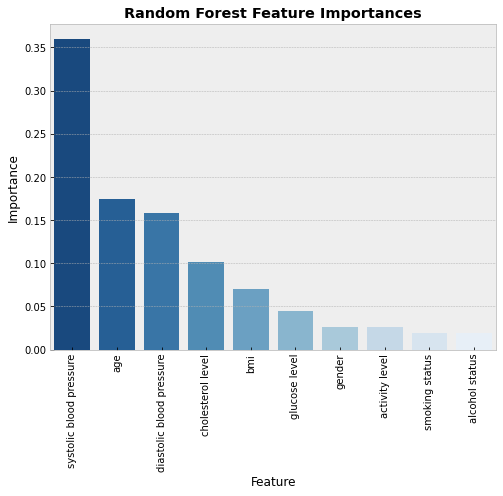

In [0]:
forest_feature_importances = pd.DataFrame(list(zip(X_train_binned.columns, np.absolute(tuned_forest_model.feature_importances_))), columns = ['feature', 'importance'])
forest_feature_importances_sorted = forest_feature_importances.sort_values(by = 'importance', ascending = False)

plt.style.use('bmh')

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
sns.barplot(data = forest_feature_importances_sorted, x = 'feature', y = 'importance', ax = ax, palette = 'Blues_r')
ax.set_title('Random Forest Feature Importances', fontweight = 'bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_xticklabels(['systolic blood pressure', 'age', 'diastolic blood pressure', 'cholesterol level', 'bmi', 'glucose level', 'gender', 'activity level', 'smoking status', 'alcohol status'])
plt.xticks(rotation = 90);

### Random Forest with "AdaBoost"

#### Baseline Model

##### Training Model

In [0]:
ada_boost = AdaBoostClassifier()
base_ada_boost_model = ada_boost.fit(X_train_binned, y_train)

y_test_hat = base_ada_boost_model.predict(X_test_binned)

##### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.722, auc_score = 0.722

precision = 0.759, recall = 0.651, f1-score = 0.701


#### Hyperparameter Tuning

##### Inspecting range for max depth

In [0]:
depths = range(1,11)
scores = []
for depth in depths:
    ada_boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = depth))
    score = np.mean(cross_val_score(ada_boost, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

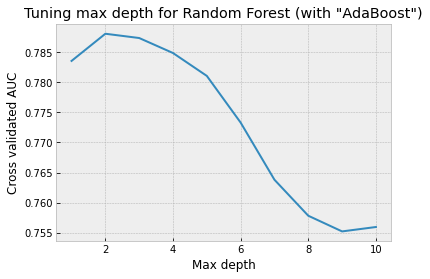

In [0]:
plt.plot(depths, scores)
plt.title('Tuning max depth for Random Forest (with "AdaBoost")')
plt.xlabel('Max depth')
plt.ylabel('Cross validated AUC');

##### Inspecting range for learning rate 

In [0]:
learning_rates = np.arange(0.2,2,0.2)
scores = []
for learning_rate in learning_rates:
    ada_boost = AdaBoostClassifier(learning_rate = learning_rate)
    score = np.mean(cross_val_score(ada_boost, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

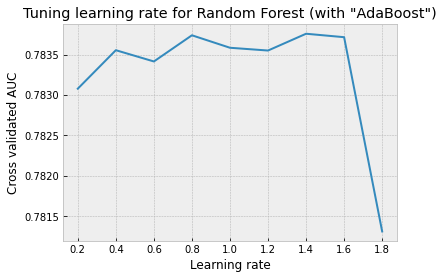

In [0]:
plt.plot(learning_rates, scores)
plt.title('Tuning learning rate for Random Forest (with "AdaBoost")')
plt.xlabel('Learning rate')
plt.ylabel('Cross validated AUC');

##### Inspecting range for number of trees

In [0]:
n_trees = np.arange(10, 110, 10)
scores = []
for n in n_trees:
    ada_boost = AdaBoostClassifier(n_estimators = n)
    score = np.mean(cross_val_score(ada_boost, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

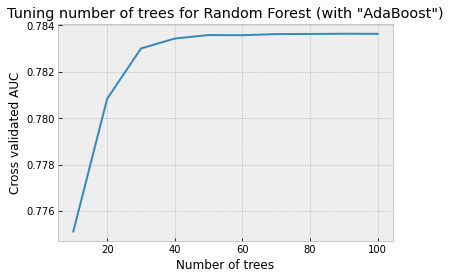

In [0]:
plt.plot(n_trees, scores)
plt.title('Tuning number of trees for Random Forest (with "AdaBoost")')
plt.xlabel('Number of trees')
plt.ylabel('Cross validated AUC');

##### Tuning max depth, learning rate and number of trees

In [0]:
param_grid = {'base_estimator': [DecisionTreeClassifier(max_depth = i) for i in range(1,5)], 'n_estimators': range(40,70,10), 'learning_rate': np.arange(0.8,1.4,0.2)}
ada_boost_gs = GridSearchCV(ada_boost, param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
%time ada_boost_gs.fit(X_train_binned, y_train)
ada_boost_gs.best_params_

CPU times: user 5.11 s, sys: 299 ms, total: 5.41 s
Wall time: 5min 53s


{'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=2, max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=None, splitter='best'),
 'learning_rate': 0.8,
 'n_estimators': 60}

#### Tuned Model

##### Training Model

In [0]:
tuned_ada_boost = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 2), learning_rate = 0.8, n_estimators = 60)
tuned_ada_boost_model = tuned_ada_boost.fit(X_train_binned, y_train)

y_test_hat = tuned_ada_boost_model.predict(X_test_binned)
y_test_proba = tuned_ada_boost_model.predict_proba(X_test_binned)[:,1]

##### Model Report

Random Forest (with "AdaBoost") Model Report


- performance metrics (default threshold):

accuracy = 0.727, auc_score = 0.727

precision = 0.741, recall = 0.7, f1-score = 0.72

- ROC curve:



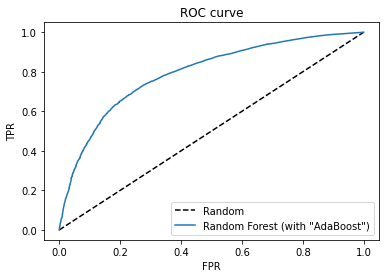


- optimal probability threshold:

0.499

- precision recall tradeoff:



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


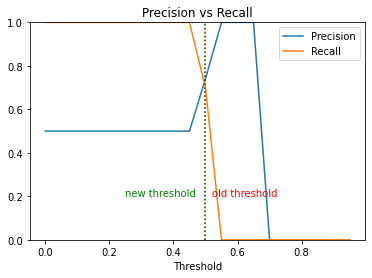


- performance metrics (new threshold):

accuracy = 0.728, auc_score = 0.728

precision = 0.73, recall = 0.723, f1-score = 0.726

- confusion matrix:



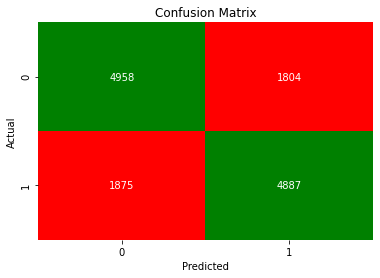

In [27]:
model_report(y_test, y_test_hat, y_test_proba, 'Random Forest (with "AdaBoost")')

##### Plotting Feature Importances

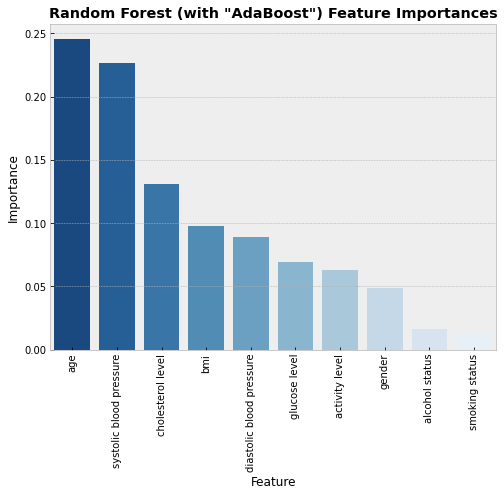

In [0]:
ada_boost_feature_importances = pd.DataFrame(list(zip(X_train_binned.columns, np.absolute(tuned_ada_boost_model.feature_importances_))), columns = ['feature', 'importance'])
ada_boost_feature_importances_sorted = ada_boost_feature_importances.sort_values(by = 'importance', ascending = False)

plt.style.use('bmh')

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
sns.barplot(data = ada_boost_feature_importances_sorted, x = 'feature', y = 'importance', ax = ax, palette = 'Blues_r')
ax.set_title('Random Forest (with "AdaBoost") Feature Importances', fontweight = 'bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_xticklabels(['age', 'systolic blood pressure', 'cholesterol level',  'bmi', 'diastolic blood pressure', 'glucose level', 'activity level', 'gender', 'alcohol status', 'smoking status'])
plt.xticks(rotation = 90);

### Random Forest with "Gradient Boosting"

#### Baseline Model

##### Training Model

In [0]:
grad_boost = GradientBoostingClassifier()
grad_boost_model = grad_boost.fit(X_train_binned, y_train)

y_test_hat = grad_boost_model.predict(X_test_binned)

##### Validating Model

In [0]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.73, auc_score = 0.73

precision = 0.737, recall = 0.714, f1-score = 0.725


#### Hyperparameter Tuning

##### Inspecting range for max depth

In [0]:
depths = range(1,11)
scores = []
for depth in depths:
    gradient_boost = GradientBoostingClassifier(max_depth = depth)
    score = np.mean(cross_val_score(gradient_boost, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

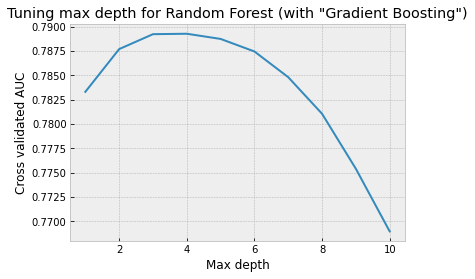

In [0]:
plt.plot(depths, scores)
plt.title('Tuning max depth for Random Forest (with "Gradient Boosting")')
plt.xlabel('Max depth')
plt.ylabel('Cross validated AUC');

##### Inspecting range for learning rate

In [0]:
learning_rates = np.arange(0.02,0.22,0.02)
scores = []
for learning_rate in learning_rates:
    gradient_boost = GradientBoostingClassifier(learning_rate = learning_rate)
    score = np.mean(cross_val_score(gradient_boost, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

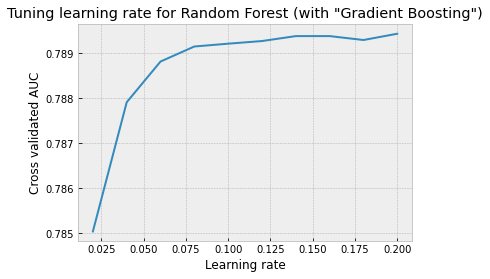

In [0]:
plt.plot(learning_rates, scores)
plt.title('Tuning learning rate for Random Forest (with "Gradient Boosting")')
plt.xlabel('Learning rate')
plt.ylabel('Cross validated AUC');

##### Inspecting range for number of trees

In [0]:
n_trees = range(10,160,10)
scores = []
for n in n_trees:
    gradient_boost = GradientBoostingClassifier(n_estimators = n)
    score = np.mean(cross_val_score(gradient_boost, X_train_binned, y_train, scoring = 'roc_auc', cv = 5))
    scores.append(score)

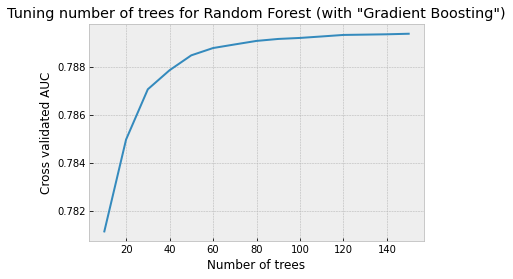

In [0]:
plt.plot(n_trees, scores)
plt.title('Tuning number of trees for Random Forest (with "Gradient Boosting")')
plt.xlabel('Number of trees')
plt.ylabel('Cross validated AUC');

##### Tuning max depth, learning rate and number of trees

In [0]:
param_grid = {'max_depth': range(3,6), 'n_estimators': range(80,140,20), 'learning_rate': np.arange(0.1,0.25,0.05)}
gradient_boost_gs = GridSearchCV(gradient_boost, param_grid, scoring = 'roc_auc', cv = 5, n_jobs = -1)
%time gradient_boost_gs.fit(X_train_binned, y_train)
gradient_boost_gs.best_params_

CPU times: user 4.95 s, sys: 204 ms, total: 5.15 s
Wall time: 4min 31s


{'learning_rate': 0.20000000000000004, 'max_depth': 3, 'n_estimators': 120}

#### Tuned Model

##### Training Model

In [0]:
tuned_grad_boost = GradientBoostingClassifier(learning_rate = 0.2, n_estimators = 120)
tuned_grad_boost_model = tuned_grad_boost.fit(X_train_binned, y_train)

y_test_hat = tuned_grad_boost_model.predict(X_test_binned)
y_test_proba = tuned_grad_boost_model.predict_proba(X_test_binned)[:,1]

##### Model Report

Random Forest (with "Gradient Boosting") Model Report


- performance metrics (default threshold):

accuracy = 0.729, auc_score = 0.729

precision = 0.738, recall = 0.709, f1-score = 0.723

- ROC curve:



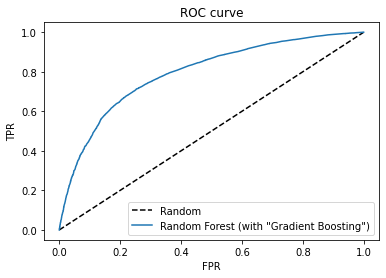


- optimal probability threshold:

0.496

- precision recall tradeoff:



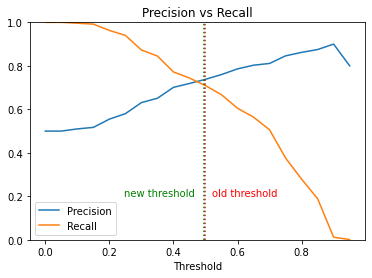


- performance metrics (new threshold):

accuracy = 0.73, auc_score = 0.73

precision = 0.738, recall = 0.713, f1-score = 0.725

- confusion matrix:



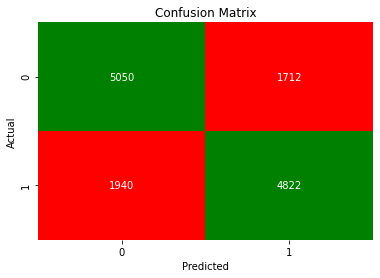

In [10]:
model_report(y_test, y_test_hat, y_test_proba, 'Random Forest (with "Gradient Boosting")')

##### Plotting Feature Importances

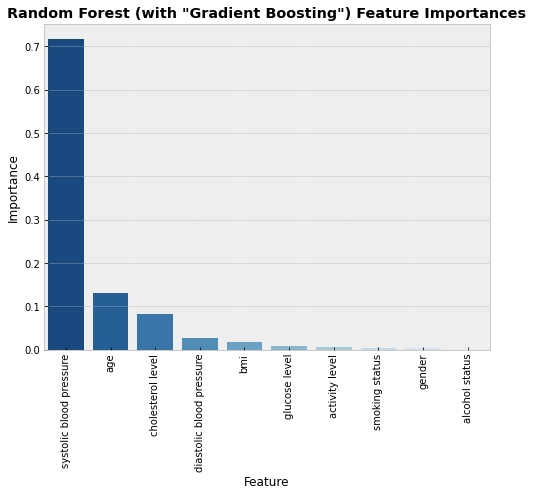

In [0]:
grad_boost_feature_importances = pd.DataFrame(list(zip(X_train_binned.columns, np.absolute(tuned_grad_boost_model.feature_importances_))), columns = ['feature', 'importance'])
grad_boost_feature_importances_sorted = grad_boost_feature_importances.sort_values(by = 'importance', ascending = False)

plt.style.use('bmh')

fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(111)
sns.barplot(data = grad_boost_feature_importances_sorted, x = 'feature', y = 'importance', ax = ax, palette = 'Blues_r')
ax.set_title('Random Forest (with "Gradient Boosting") Feature Importances', fontweight = 'bold')
ax.set_xlabel('Feature')
ax.set_ylabel('Importance')
ax.set_xticklabels(['systolic blood pressure', 'age', 'cholesterol level', 'diastolic blood pressure', 'bmi', 'glucose level', 'activity level', 'smoking status', 'gender', 'alcohol status'])
plt.xticks(rotation = 90);

## Other Ensemble Models

### Bagged Classifiers

#### Logistic Regression with "Bagging"

##### Training Model

In [0]:
lr_bagged = BaggingClassifier(base_estimator = lr)
lr_bagged_model = lr_bagged.fit(X_train_scaled, y_train)

y_test_hat = lr_bagged_model.predict(X_test_scaled)
y_test_proba = lr_bagged_model.predict_proba(X_test_scaled)[:,1]

##### Model Report

Logistic Regression with "Bagging" Model Report


- performance metrics (default threshold):

accuracy = 0.731, auc_score = 0.731

precision = 0.759, recall = 0.678, f1-score = 0.716

- ROC curve:



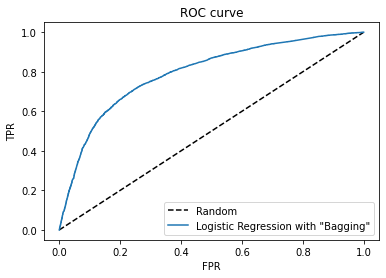


- optimal probability threshold:

0.463

- precision recall tradeoff:



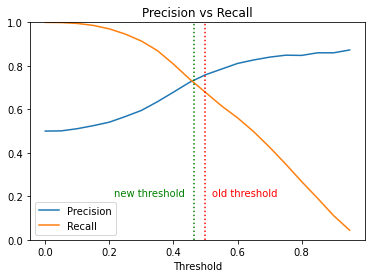


- performance metrics (new threshold):

accuracy = 0.732, auc_score = 0.732

precision = 0.736, recall = 0.723, f1-score = 0.729

- confusion matrix:



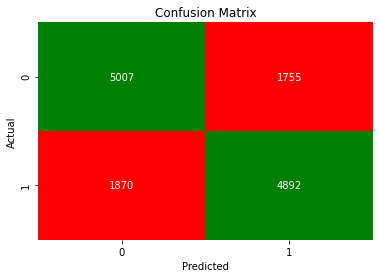

In [53]:
model_report(y_test, y_test_hat, y_test_proba, 'Logistic Regression with "Bagging"')

#### k-Nearest Neighbours with "Bagging"

##### Training Model

In [0]:
knn_bagged = BaggingClassifier(base_estimator = tuned_knn)
knn_bagged_model = knn_bagged.fit(X_train_scaled, y_train)

y_test_hat = knn_bagged_model.predict(X_test_scaled)
y_test_proba = knn_bagged_model.predict_proba(X_test_scaled)[:,1]

##### Model Report

k-Nearest Neighbours with "Bagging" Model Report


- performance metrics (default threshold):

accuracy = 0.733, auc_score = 0.733

precision = 0.756, recall = 0.689, f1-score = 0.721

- ROC curve:



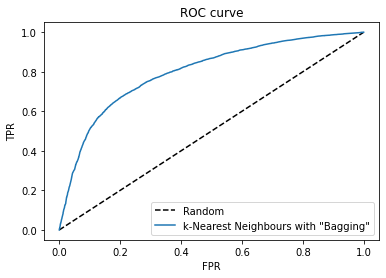


- optimal probability threshold:

0.452

- precision recall tradeoff:



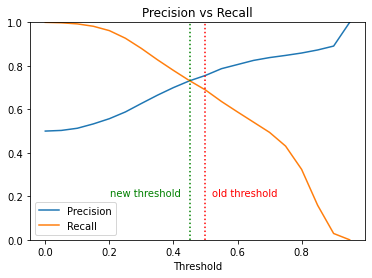


- performance metrics (new threshold):

accuracy = 0.731, auc_score = 0.731

precision = 0.732, recall = 0.73, f1-score = 0.731

- confusion matrix:



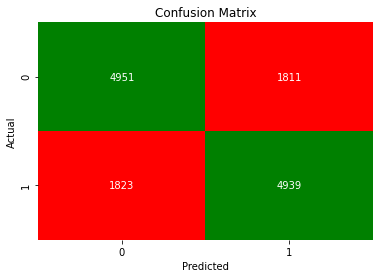

In [55]:
model_report(y_test, y_test_hat, y_test_proba, 'k-Nearest Neighbours with "Bagging"')

#### Naive Bayes with "Bagging"

##### Training Model

In [0]:
nb_bagged = BaggingClassifier(base_estimator = nb)
nb_bagged_model = nb_bagged.fit(X_train_binned, y_train)

y_test_hat = nb_bagged_model.predict(X_test_binned)
y_test_proba = nb_bagged_model.predict_proba(X_test_binned)[:,1]

##### Model Report

Categorical Naive Bayes with "Bagging" Model Report


- performance metrics (default threshold):

accuracy = 0.72, auc_score = 0.72

precision = 0.755, recall = 0.654, f1-score = 0.701

- ROC curve:



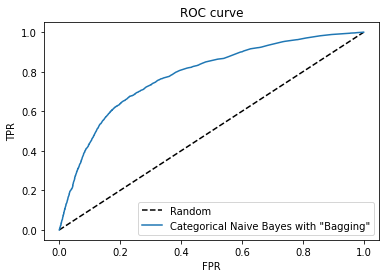


- optimal probability threshold:

0.402

- precision recall tradeoff:



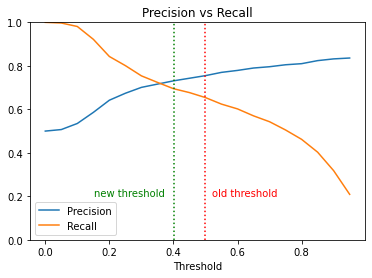


- performance metrics (new threshold):

accuracy = 0.72, auc_score = 0.72

precision = 0.732, recall = 0.694, f1-score = 0.712

- confusion matrix:



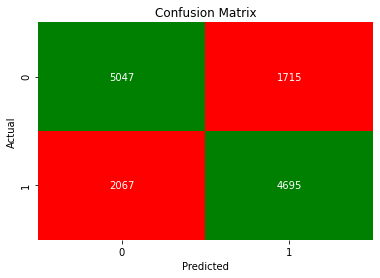

In [63]:
model_report(y_test, y_test_hat, y_test_proba, 'Naive Bayes with "Bagging"')

### Voting Classifiers

#### Hard Voting Classifier

##### Training Model

In [0]:
hard_voting_models = [(lr_model, "scaled"), (tuned_knn_model, "scaled"), (nb_model, "binned"), (rbf_svm_model, "scaled"), (tuned_tree, "binned")]

y_test_hat = voting_classifier(hard_voting_models, X_test)

##### Validating Model

In [17]:
classification_metrics(y_test, y_test_hat)

accuracy = 0.736, auc_score = 0.736

precision = 0.763, recall = 0.684, f1-score = 0.721


#### Soft Voting Classifier

##### Training Model

In [0]:
soft_voting_models = [(lr_model, "scaled"), (tuned_knn_model, "scaled"), (nb_model, "binned"), (tuned_tree_model, "binned")]

y_test_hat, y_test_proba = voting_classifier(soft_voting_models, X_test, hard = False)

##### Model Report

Soft Voting Classifier Model Report


- performance metrics (default threshold):

accuracy = 0.731, auc_score = 0.731

precision = 0.76, recall = 0.675, f1-score = 0.715

- ROC curve:



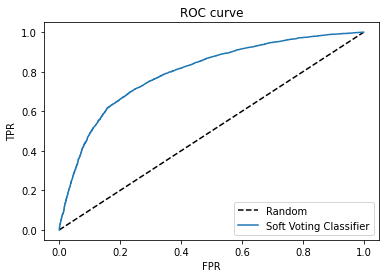


- optimal probability threshold:

0.458

- precision recall tradeoff:



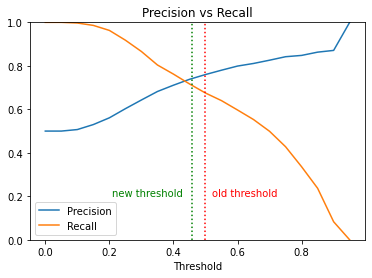


- performance metrics (new threshold):

accuracy = 0.732, auc_score = 0.732

precision = 0.743, recall = 0.71, f1-score = 0.726

- confusion matrix:



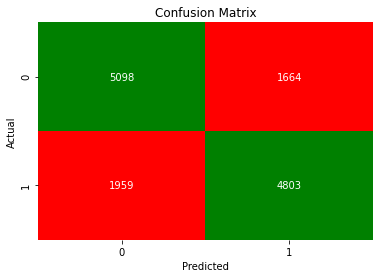

In [19]:
model_report(y_test, y_test_hat, y_test_proba, "Soft Voting Classifier")

### Stacked Classifier

#### Training Model

In [0]:
stacked_models = [(lr, "scaled"), (tuned_knn, "scaled"), (nb, "binned"), (tuned_tree, "binned")]
y_test_hat, y_test_proba = stacked_model(stacked_models, X_train, X_test, y_train)

#### Model Report

Stacked Model Model Report


- performance metrics (default threshold):

accuracy = 0.734, auc_score = 0.734

precision = 0.752, recall = 0.699, f1-score = 0.725

- ROC curve:



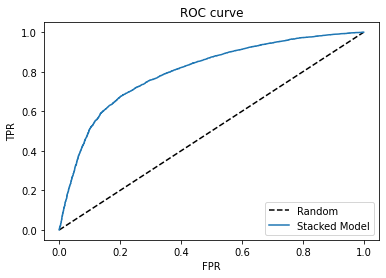


- optimal probability threshold:

0.467

- precision recall tradeoff:



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


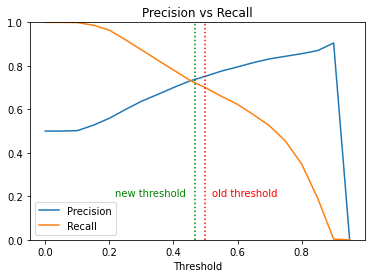


- performance metrics (new threshold):

accuracy = 0.734, auc_score = 0.734

precision = 0.739, recall = 0.723, f1-score = 0.731

- confusion matrix:



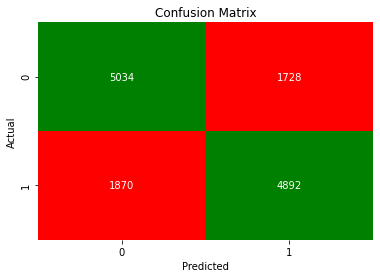

In [21]:
model_report(y_test, y_test_hat, y_test_proba, "Stacked Model")

# Model Selection

In [0]:
model_performances = [{'model_type': 'base', 'model_name': 'Logistic Regression', 'auc': 0.732, 'precision': 0.734, 'recall': 0.732, 'threshold': 0.46},
 {'model_type': 'base', 'model_name': 'k-Nearest Neighbours', 'auc': 0.733, 'precision': 0.754, 'recall': 0.693, 'threshold': 0.49},
 {'model_type': 'base', 'model_name': 'Naive Bayes', 'auc': 0.719, 'precision': 0.721, 'recall': 0.714, 'threshold': 0.46},
 {'model_type': 'base', 'model_name': 'Support Vector Machine', 'auc': 0.737, 'precision': 0.769, 'recall': 0.677, 'threshold': 0.5},
 {'model_type': 'base', 'model_name': 'Neural Network', 'auc': 0.737, 'precision': 0.765, 'recall': 0.683, 'threshold': 0.468},
 {'model_type': 'base', 'model_name': 'Decision Tree', 'auc': 0.729, 'precision': 0.738, 'recall': 0.71, 'threshold': 0.476},
 {'model_type': 'ensemble', 'model_name': 'Random Forest', 'auc': 0.728, 'precision': 0.733, 'recall': 0.717, 'threshold': 0.475},
 {'model_type': 'ensemble', 'model_name': 'Random Forest, with Adaptive Boosting', 'auc': 0.728, 'precision': 0.73, 'recall': 0.723, 'threshold': 0.499},
 {'model_type': 'ensemble', 'model_name': 'Random Forest, with Gradient Boosting', 'auc': 0.73, 'precision': 0.738, 'recall': 0.713, 'threshold': 0.496},
 {'model_type': 'ensemble', 'model_name': 'Logistic Regression, with Bagging', 'auc': 0.732, 'precision': 0.736, 'recall': 0.723, 'threshold': 0.463},
 {'model_type': 'ensemble', 'model_name': 'k-Nearest Neighbours, with Bagging', 'auc': 0.731, 'precision': 0.732, 'recall': 0.73, 'threshold': 0.452},
 {'model_type': 'ensemble', 'model_name': 'Naive Bayes, with Bagging', 'auc': 0.72, 'precision': 0.732, 'recall': 0.694, 'threshold': 0.402},
 {'model_type': 'ensemble', 'model_name': 'Hard Voting Classifier', 'auc': 0.736, 'precision': 0.763, 'recall': 0.684, 'threshold': 0.5},
 {'model_type': 'ensemble', 'model_name': 'Soft Voting Classifier', 'auc': 0.732, 'precision': 0.743, 'recall': 0.71, 'threshold': 0.458},
 {'model_type': 'ensemble', 'model_name': 'Stacked Classifer', 'auc': 0.734, 'precision': 0.739, 'recall': 0.723, 'threshold': 0.467}]

In [0]:
model_performances = pd.DataFrame.from_dict(model_performances)

base_models = model_performances.loc[model_performances['model_type'] == 'base'].drop(columns = ['model_type'])
ensemble_models = model_performances.loc[model_performances['model_type'] == 'ensemble'].drop(columns = ['model_type'])

In [108]:
base_models.sort_values(by = 'auc', ascending = False)

,model_name,auc,precision,recall,threshold
3,Support Vector Machine,0.737,0.769,0.677,0.500
4,Neural Network,0.737,0.765,0.683,0.468
1,k-Nearest Neighbours,0.733,0.754,0.693,0.490
0,Logistic Regression,0.732,0.734,0.732,0.460
5,Decision Tree,0.729,0.738,0.710,0.476
2,Naive Bayes,0.719,0.721,0.714,0.460


In [109]:
ensemble_models.sort_values(by = 'auc', ascending = False)

,model_name,auc,precision,recall,threshold
12,Hard Voting Classifier,0.736,0.763,0.684,0.500
14,Stacked Classifer,0.734,0.739,0.723,0.467
9,"Logistic Regression, with Bagging",0.732,0.736,0.723,0.463
13,Soft Voting Classifier,0.732,0.743,0.710,0.458
10,"k-Nearest Neighbours, with Bagging",0.731,0.732,0.730,0.452
8,"Random Forest, with Gradient Boosting",0.730,0.738,0.713,0.496
6,Random Forest,0.728,0.733,0.717,0.475
7,"Random Forest, with Adaptive Boosting",0.728,0.730,0.723,0.499
11,"Naive Bayes, with Bagging",0.720,0.732,0.694,0.402


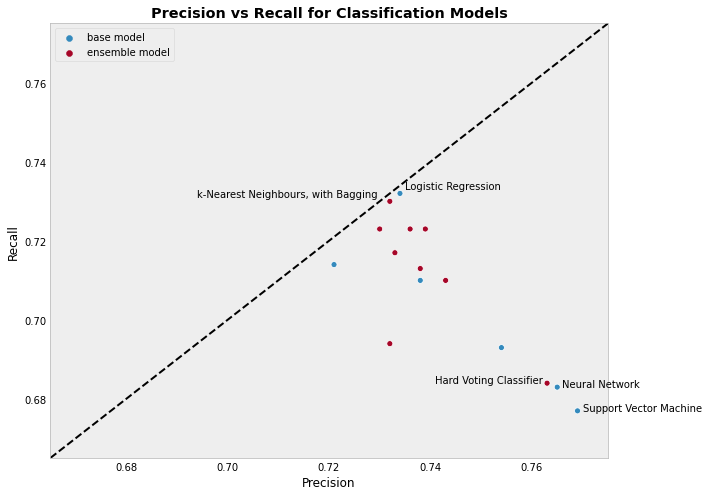

In [105]:
plt.style.use('bmh')

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
sns.scatterplot(x = 'precision', y = 'recall', hue = 'model_type', data = model_performances, ax = ax)
ax.plot([0,1], [0,1], ls = '--', c = 'black')
ax.grid(False)
ax.tick_params(axis='both', length = 0)
ax.text(0.694, 0.731, 'k-Nearest Neighbours, with Bagging')
ax.text(0.735, 0.733, 'Logistic Regression')
ax.text(0.77, 0.677, 'Support Vector Machine')
ax.text(0.766, 0.683, 'Neural Network')
ax.text(0.741, 0.684, 'Hard Voting Classifier')
ax.set_title('Precision vs Recall for Classification Models', fontweight = 'bold')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.set_xlim((0.665, 0.775))
ax.set_ylim((0.665, 0.775))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=['base model', 'ensemble model'], loc = "upper left");